In [113]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd

from datetime import datetime

import importlib

from tqdm import tqdm

In [114]:
satds = xr.open_mfdataset('/home/pxv220016/petastore_shared_folder/Prasoon_satellite_project/sat_files_for_phil/20130317/F16.nc').load()

In [115]:
#!!!!! SOMEONE (Prasoon) needs to make this file. Use the default regridding settings to interpolate the SAMI outputs to a geographic grid.

samids = xr.open_mfdataset('/home/pxv220016/petastore_shared_folder/Prasoon_satellite_project/glob__SAMI_REGRID.nc').load() # PATH TO SAMI REGRID (NORMAL RUN)

In [116]:
samids

<xarray.Dataset>
Dimensions:  (time: 307, alt: 80, lat: 90, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17T00:09:57.600000 ... 2013-03-18T...
  * alt      (alt) int64 200 225 250 275 300 325 ... 2075 2100 2125 2150 2175
  * lat      (lat) int64 -90 -88 -86 -84 -82 -80 -78 ... 76 78 80 82 84 86 88
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lon, lat, alt) float64 1.23e+05 2.118e+05 ... 0.0 0.0

In [117]:
satlocdf = pd.read_csv('/petastore/phil/Prasoon_satellite_project/satfiles/20130317/DMSP_all-with_datetime.csv')

f16 = satlocdf.where(satlocdf.sat == 16.0).dropna().reset_index(drop=True)

In [119]:
'''
SELF-NOTE
Note that the e_dens is having a dimension of 597*4320
this is due to the fact that at any time, sami is able
to calculate density at all the points. However, the
satellite data can only calculate the density of the 
coordinate at which it is present. So, get the glat and
glon at a particular point using the sat_time and then
use sami_time that is nearer to this sat_time.
'''

satds


<xarray.Dataset>
Dimensions:    (sami_time: 597, sat_time: 4320)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:39:54
    glat       (sat_time) float64 2.8 6.3 9.8 13.3 16.8 ... 53.3 49.9 46.5 43.0
    glon       (sat_time) float64 261.2 260.5 259.7 258.9 ... 92.7 91.2 89.9
  * sat_time   (sat_time) datetime64[ns] 2013-03-16 ... 2013-03-18T23:59:00
Data variables:
    e_dens     (sami_time, sat_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [121]:
f16

,glat,glon,time,sat,dayofyear,dtime
0,2.8,261.2,0.0,16.0,75.0,2013-03-16 00:00:00
1,6.3,260.5,60.0,16.0,75.0,2013-03-16 00:01:00
2,9.8,259.7,120.0,16.0,75.0,2013-03-16 00:02:00
3,13.3,258.9,180.0,16.0,75.0,2013-03-16 00:03:00
4,16.8,258.0,240.0,16.0,75.0,2013-03-16 00:04:00
...,...,...,...,...,...,...
4315,56.7,96.1,86100.0,16.0,77.0,2013-03-18 23:55:00
4316,53.3,94.3,86160.0,16.0,77.0,2013-03-18 23:56:00
4317,49.9,92.7,86220.0,16.0,77.0,2013-03-18 23:57:00
4318,46.5,91.2,86280.0,16.0,77.0,2013-03-18 23:58:00


In [122]:
# All the Satellite passes possible

from scipy.signal import find_peaks

max_ind, _ = find_peaks(satds['glat'])
min_ind, _ = find_peaks(-satds['glat'])
print('Indices of maximum latitude -', max_ind)
print()
print('Indices of minimum latitude -', min_ind)

pass_num = 10
start_ind = max_ind[pass_num]
end_ind = min_ind[pass_num]

Indices of maximum latitude - [  25  127  229  330  432  534  636  738  840  942 1044 1146 1248 1350
 1452 1554 1656 1758 1859 1961 2063 2165 2267 2369 2471 2573 2675 2777
 2879 2981 3083 3185 3287 3388 3490 3592 3694 3796 3898 4000 4102 4204
 4306]

Indices of minimum latitude - [  76  178  279  381  483  585  687  789  891  993 1095 1197 1299 1401
 1503 1605 1707 1808 1910 2012 2114 2216 2318 2420 2522 2624 2726 2828
 2930 3032 3134 3235 3337 3439 3541 3643 3745 3847 3949 4051 4153 4255]


In [123]:
sattimes = pd.to_datetime(f16.dtime).to_numpy()

sattimes[0], sattimes[len(sattimes)-1], sattimes[1] - sattimes[0], satds.sat_time[3].values,  type(satds.isel(sat_time=0).sat_time.values)

(numpy.datetime64('2013-03-16T00:00:00.000000000'),
 numpy.datetime64('2013-03-18T23:59:00.000000000'),
 numpy.timedelta64(60000000000,'ns'),
 numpy.datetime64('2013-03-16T00:03:00.000000000'),
 numpy.datetime64)

In [160]:
from scipy.interpolate import CubicSpline


interpolated_edens = []

lat = (f16['glat'])[start_ind:end_ind+1]
lon = (f16['glon'])[start_ind:end_ind+1]
time = sattimes[start_ind:end_ind+1]

sami_start = 0
sami_end = 0

sami_time = satds['sami_time']

'''
for i in range(start_ind, end_ind+1):
    interpolated_edens.append(
        satds.isel(glat=i,glon=i, alt=840).edens.interp(sat_time=sattimes[i]).values)
'''

for i in range(len(sami_time)-1):
    if sami_time[i] <= time[0] and sami_time[i+1] > time[0]:
        sami_start = i
    if sami_time[i] <= time[-1] and sami_time[i+1] > time[-1]:
        sami_end = i
        break

#sami_passing = sami_time[sami_start:sami_end+1]
sami_passing = pd.to_datetime(sami_time[sami_start:sami_end+1]).to_numpy()

for i in range(start_ind, end_ind+1):
    sami_data = []
    sami_sec = []

    #interpolated_edens.append(
    #    satds.sel(sat_time=sattimes[i], sami_time=sattimes[i], method='nearest').e_dens.interp(sat_time=sattimes[i]).values)

    for j in range(len(sami_passing)):
        
        seconds = (sami_passing[j] - np.datetime64('2013-03-16T00:00:00Z')) / np.timedelta64(1, 's')
        sami_sec.append(seconds)
        sami_data.append(satds.sel(sami_time=sami_passing[j]).e_dens.interp(sat_time=sattimes[i]).values)
    
    cs = CubicSpline(sami_sec, sami_data)
    seconds2 = (sattimes[i] - np.datetime64('2013-03-16T00:00:00Z')) / np.timedelta64(1, 's')
    interpolated_edens.append(float(cs(seconds2)))


print('interpolated_edens', interpolated_edens)


/tmp/ipykernel_169593/504007280.py:40: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  seconds = (sami_passing[j] - np.datetime64('2013-03-16T00:00:00Z')) / np.timedelta64(1, 's')
/tmp/ipykernel_169593/504007280.py:45: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  seconds2 = (sattimes[i] - np.datetime64('2013-03-16T00:00:00Z')) / np.timedelta64(1, 's')


interpolated_edens [41203.893287179344, 46982.768695992745, 50637.34403905363, 45532.68169658318, 38215.63948924685, 32847.287075642496, 30426.012531034317, 24992.921033799044, 18868.430048010992, 18309.673510792953, 19801.373415652906, 21710.487217398935, 22709.553590157157, 21490.248824501687, 19674.003005741924, 17527.50860664732, 15972.696016436168, 14572.783979807085, 13846.810573515093, 13371.957282804306, 12818.73305279519, 12486.19101333358, 12478.965961230402, 12705.91890278389, 12981.821560081275, 12809.63324806098, 12444.645537177887, 11078.983506998535, 9551.19763010096, 8800.894960577067, 8910.419070023461, 9119.956105583258, 9545.51534669245, 9864.210873803162, 9912.736466015791, 9527.212660073494, 8509.891729483556, 6962.648602997659, 5607.2702690697915, 4257.510114065811, 3391.6668512106075, 3422.4171474194354, 4464.627405093431, 5325.2131171166375, 7589.19021827284, 10489.466168340072, 12476.89295863312, 17742.072294472757, 20870.212935209824, 17154.884710760125, 15155

['17:24:00', '17:34:00', '17:44:00', '17:54:00', '18:04:00', '18:14:00']


Text(0.5, 0, 'sat_time')

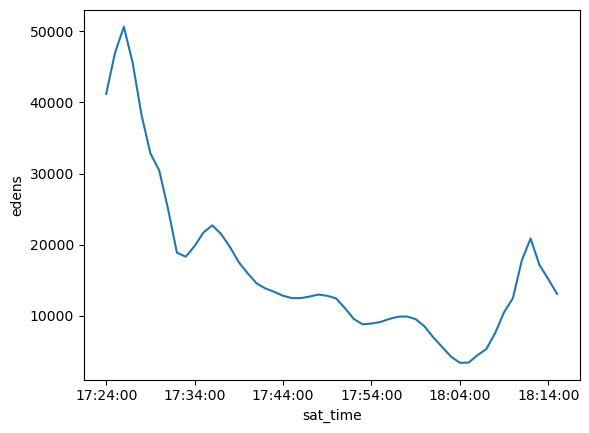

In [170]:
x_ticks = []
labels = []
for i in range(start_ind, end_ind, 10):
    x_ticks.append(i - start_ind)
    labels.append((sattimes[i]).astype('datetime64[s]').astype(str)[-8:])
print(labels)

plt.figure()
plt.plot(interpolated_edens)
plt.xticks(x_ticks, labels=labels)
plt.ylabel('edens')
plt.xlabel('sat_time')

^^^ INSTEAD OF THAT, DO:

In [64]:
f16['edens'] = interpolated_edens

In [65]:
np.sum(f16.edens > 3) / len(f16)

0.6895833333333333

In [66]:
# Only ~70% valid points... why? not sure!
# That is a job for prasoon to figure out, lol

In [67]:
f16

,glat,glon,time,sat,dayofyear,dtime,edens
0,2.8,261.2,0.0,16.0,75.0,2013-03-16 00:00:00,0.0
1,6.3,260.5,60.0,16.0,75.0,2013-03-16 00:01:00,4807.165583010137
2,9.8,259.7,120.0,16.0,75.0,2013-03-16 00:02:00,9638.638426857176
3,13.3,258.9,180.0,16.0,75.0,2013-03-16 00:03:00,14369.45259595565
4,16.8,258.0,240.0,16.0,75.0,2013-03-16 00:04:00,19460.296604329455
...,...,...,...,...,...,...,...
4315,56.7,96.1,86100.0,16.0,77.0,2013-03-18 23:55:00,nan
4316,53.3,94.3,86160.0,16.0,77.0,2013-03-18 23:56:00,nan
4317,49.9,92.7,86220.0,16.0,77.0,2013-03-18 23:57:00,nan
4318,46.5,91.2,86280.0,16.0,77.0,2013-03-18 23:58:00,nan


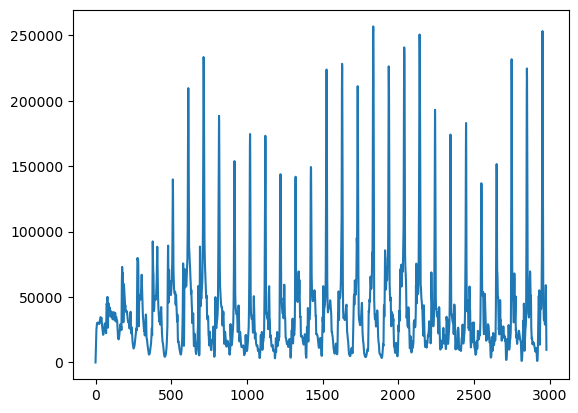

In [23]:
plt.plot(f16.edens)

In [ ]:
lochere = 50


# one satellite location throughout time...
satds.isel(lat=lochere,lon=lochere, alt=0).edens.plot()

plt.show()

# Plot that longitude, what do TIDs look like?

samids.sel(alt=840, lon=satds.isel(lon=50).lon.values).plot(x='time')
plt.title('RAW')


plt.show()


# Now the filtered values...
# # Obviously change {} and everything inside
# You can use custom bandpass filtering routines if you want, but some have been made already...
filters.{"SEL A FILTER"}(samids.sel(alt=840, lon=satds.isel(lon=50).lon.values).plot(x='time'))
plt.title('FILTERED')



In [26]:
# Find a satellite pass where there are non 0's or nans...

In [27]:
from scipy.signal import find_peaks

In [120]:
maxmin_glons, _ = find_peaks(np.abs(f16.glat))

In [154]:
valid_passes = []

pass_start_end_time = []

for i in range(len(maxmin_glons)-1):
    # When interpolations are fixed (and there are no more nans) these lines can be uncommented:
    
    # if np.sum(f16['edens'][maxmin_glons[i]: maxmin_glons[i+1]].isna()) !=0:
        # if np.sum(f16['edens'][maxmin_glons[i]: maxmin_glons[i+1]] == 0) !=0:
            valid_passes.append([maxmin_glons[i], maxmin_glons[i+1]])
            pass_start_end_time.append([f16.dtime[maxmin_glons[i]], f16.dtime[maxmin_glons[i+1]]])

In [155]:
# find satellite passes that are after storm onset
in_storm = [pd.Timestamp(t) > pd.Timestamp('2013-3-17 6:00') for t in pass_start_time] # array of bools
stormtime_pass_idxs = []
times_of_passes = []

for t in range(len(in_storm)):
    if in_storm[t]:
        stormtime_pass_idxs.append(valid_passes[t])
        times_of_passes.append(pass_start_end_time[t])

In [156]:
np.sum(in_storm), len(valid_passes), len(stormtime_pass_idxs)

(49, 84, 49)

In [157]:
numpass = 5 # pick a pass

In [158]:
selected_pass = f16.iloc[stormtime_pass_idxs[numpass][0]:stormtime_pass_idxs[numpass][1]]


In [159]:
selected_pass.head()

,glat,glon,time,sat,dayofyear,dtime,edens
2063,81.3,23.6,37380.0,16.0,76.0,2013-03-17 10:23:00,27612.48507828931
2064,81.1,0.2,37440.0,16.0,76.0,2013-03-17 10:24:00,27558.521509473296
2065,79.6,340.7,37500.0,16.0,76.0,2013-03-17 10:25:00,26731.180903385637
2066,77.3,327.1,37560.0,16.0,76.0,2013-03-17 10:26:00,26892.785159020077
2067,74.5,317.9,37620.0,16.0,76.0,2013-03-17 10:27:00,42166.615347114974


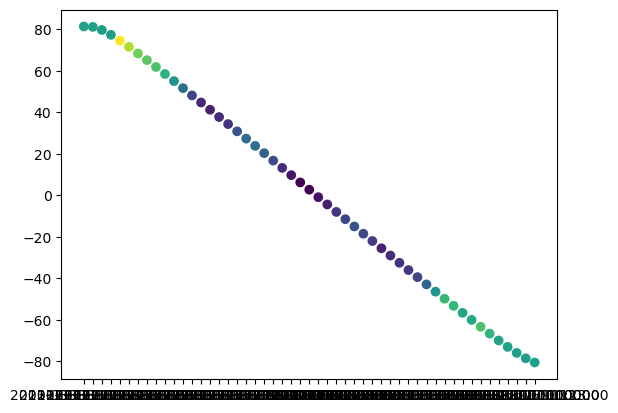

In [160]:
plt.scatter(selected_pass['dtime'], selected_pass['glat'], c=selected_pass['edens'])

In [ ]:
samids.sel(time=slice(times_of_passes[numpass][0], times_of_passes[numpass][1]), lon=np.median(selected_pass.glon), method='nearest').edens.plot(x='time', y='lat')

In [ ]:
samids.sel(time=slice(times_of_passes[numpass][0], times_of_passes[numpass][1]), lon=np.median(selected_pass.glon), method='nearest').edens.plot(x='time', y='lat')
plt.scatter(selected_pass['dtime'], selected_pass['glat'], c=selected_pass['edens'])

In [ ]:
# Then do the same with background removed, figure out how to remove background from the satellite pass....
# Someone presented this at a conference and did a bandpass filter with limits at 300 & 600 seconds.

# Since we have the satellite uinterpolated at every location and at every time we can verify background removal with that.


In [ ]:
samids.edens.integrate('alt').sel( """ AT A SATELLITE PASS """ ).plot()